<a href="https://colab.research.google.com/github/David-Delatorre/CECS-456-Project/blob/main/CECS456_ResNetV2_Model2_CNN_Project_V2_David_Delatorre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#importing libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import backend as k
!pip install opendatasets
import opendatasets as od

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# need kaggle username and password
od.download(
	"https://www.kaggle.com/datasets/andrewmvd/medical-mnist")


!pip install -Uqq fastai
from pathlib import Path
from fastai.metrics import error_rate
from fastai.vision.all import *
!pip install timm
import timm
import torch
import pickle
path=Path('../content/medical-mnist');
path

# List files in the dataset to verify
import os
print(os.listdir(path))

Mounted at /content/drive
Skipping, found downloaded files in "./medical-mnist" (use force=True to force download)
['CXR', 'Hand', 'BreastMRI', 'train', 'val', 'ChestCT', 'AbdomenCT', 'test', 'HeadCT']


In [11]:
import os
import shutil
from pathlib import Path
import random

# Define the paths to the subdirectories
root_path = path  # Change this to your actual path
categories = ['CXR', 'Hand', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'HeadCT']

# Define paths for training, validation, and test sets
train_path = root_path / 'train'
valid_path = root_path / 'val'
test_path = root_path / 'test'

# Create directories if they don't exist
for split in [train_path, valid_path, test_path]:
    split.mkdir(parents=True, exist_ok=True)

# Create subdirectories within each split for each category
for split in [train_path, valid_path, test_path]:
    for category in categories:
        (split / category).mkdir(parents=True, exist_ok=True)

# Function to split images into train, val, and test sets
def split_data(source_path, train_path, valid_path, test_path, split_ratio=(0.6, 0.2, 0.2)):
    for category in categories:
        # Get all image paths in the category
        category_path = source_path / category
        images = list(category_path.glob('*'))  # All images in the category
        random.shuffle(images)  # Shuffle the images

        # Calculate split sizes
        num_images = len(images)
        train_size = int(num_images * split_ratio[0])
        valid_size = int(num_images * split_ratio[1])

        # Split the images
        train_images = images[:train_size]
        valid_images = images[train_size:train_size+valid_size]
        test_images = images[train_size+valid_size:]

        # Move images to the corresponding directories
        for img in train_images:
            shutil.move(img, train_path / category / img.name)
        for img in valid_images:
            shutil.move(img, valid_path / category / img.name)
        for img in test_images:
            shutil.move(img, test_path / category / img.name)

# Split the data
split_data(root_path, train_path, valid_path, test_path)


test_path = "/content/medical-mnist/test"


train_path="/content/medical-mnist/train"


val_path="/content/medical-mnist/val"


# using data augmentation to prevent overfitting and handle imbalance in dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

train = Image_gen.flow_from_directory(train_path, target_size=(224, 224),
                                       batch_size=32,
                                       class_mode='categorical'
                                       )

validation = Image_gen.flow_from_directory(val_path, target_size=(224, 224),
                                              batch_size=16,
                                              class_mode='categorical'
                                            )

test = val_Datagen.flow_from_directory(test_path, target_size=(224, 224),
                                       batch_size=16,
                                       class_mode='categorical'
                                      )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)




import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2



# Load the pretrained ResNet model
resnet_base = ResNet50V2(
    weights='imagenet',  # Use weights pretrained on ImageNet
    include_top=False,   # Exclude the top layer
    input_shape=(224, 224, 3)  # Input shape (match your dataset)
)

# Freeze the base model
resnet_base.trainable = False

# Add custom classification head
model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),  # Pool features from the base model
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Regularization
    layers.Dense(6, activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
)

history = model.fit(
    train,
    validation_data=validation,
    epochs=40,
    steps_per_epoch=30,       # Define steps per epoch explicitly
    validation_steps=20,       # Define validation steps explicitly
    callbacks=[early_stopping, reduce_learning_rate],
    shuffle=True
)

Found 35372 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.
Found 11792 images belonging to 6 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step - accuracy: 0.5865 - loss: 1.1617 - precision: 0.6614 - recall: 0.4811 - val_accuracy: 0.9688 - val_loss: 0.0959 - val_precision: 0.9716 - val_recall: 0.9625 - learning_rate: 0.0010
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 744ms/step - accuracy: 0.9484 - loss: 0.1672 - precision: 0.9568 - recall: 0.9381 - val_accuracy: 0.9844 - val_loss: 0.0599 - val_precision: 0.9905 - val_recall: 0.9812 - learning_rate: 0.0010
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 663ms/step - accuracy: 0.9722 - loss: 0.0973 - precision: 0.9796 - recall: 0.9652 - val_accuracy: 0.9875 - val_loss: 0.0519 - val_precision: 0.9875 - val_recall: 0.9875 - learning_rate: 0.0010
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 583ms/step - accuracy: 0.9751 - loss: 0.0832 - precision: 0.9764 - recall: 0.9728 - val_accuracy: 0.9937 - val_loss: 0.0304 - val_precision: 0.9937 - val_recall: 0.9937 - learning_rate: 0.0010
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.9818

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step - accuracy: 0.9974 - loss: 0.0140 - precision: 0.9976 - recall: 0.9974 - val_accuracy: 1.0000 - val_loss: 0.0030 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 38/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 653ms/step - accuracy: 0.9902 - loss: 0.0332 - precision: 0.9902 - recall: 0.9902 - val_accuracy: 1.0000 - val_loss: 0.0024 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 39/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - accuracy: 0.9933 - loss: 0.0263 - precision: 0.9955 - recall: 0.9933 - val_accuracy: 0.9969 - val_loss: 0.0068 - val_precision: 0.9969 - val_recall: 0.9969 - learning_rate: 1.0000e-04
Epoch 40/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 653ms/step - accuracy: 0.9989 - loss: 0.0092 - precision: 0.9989 - recall: 0.9989 - val_accuracy: 0.9937 - val_loss: 0.0130 - val_precision: 0.9937 - val_recall: 0.9937 - learning_rate: 1.0000e-05


In [12]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])
print("Train Precision: ", score[2])
print("Train Recall: ", score[3])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])
print("Test Precision: ", score[2])
print("Test Recall: ", score[3])

1106/1106 ━━━━━━━━━━━━━━━━━━━━ 536s 483ms/step - accuracy: 0.9977 - loss: 0.0077 - precision: 0.9978 - recall: 0.9976
Train Loss:  0.00788238923996687
Train Accuracy:  0.9973425269126892
Train Precision:  0.9973987936973572
Train Recall:  0.9972859621047974
737/737 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9981 - loss: 0.0042 - precision: 0.9981 - recall: 0.9980

Test loss:  0.0040092491544783115
Test Accuracy:  0.9985583424568176
Test Precision:  0.9985581040382385
Test Recall:  0.9983887672424316


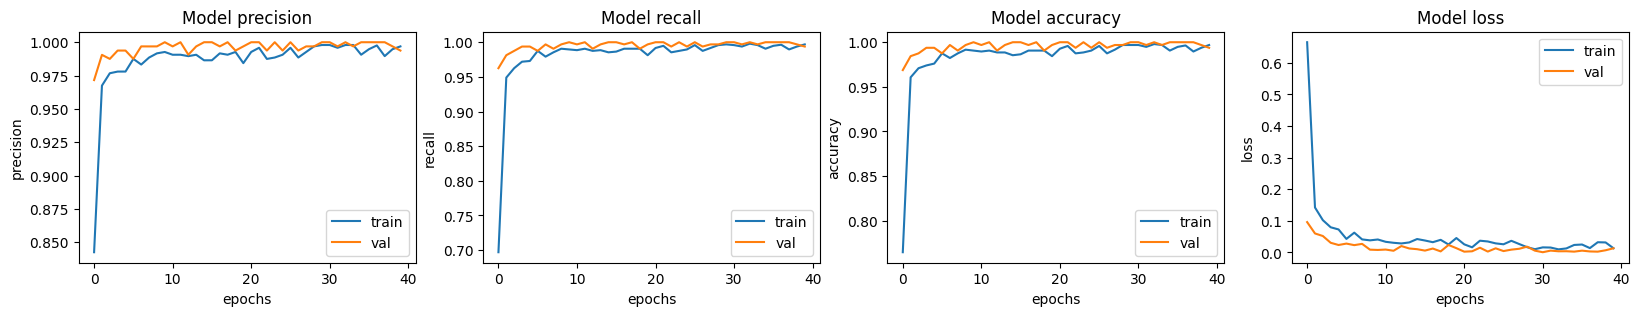

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
predictions = model.predict(test, steps=len(test), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

737/737 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step


[0 0 0 ... 5 5 5]


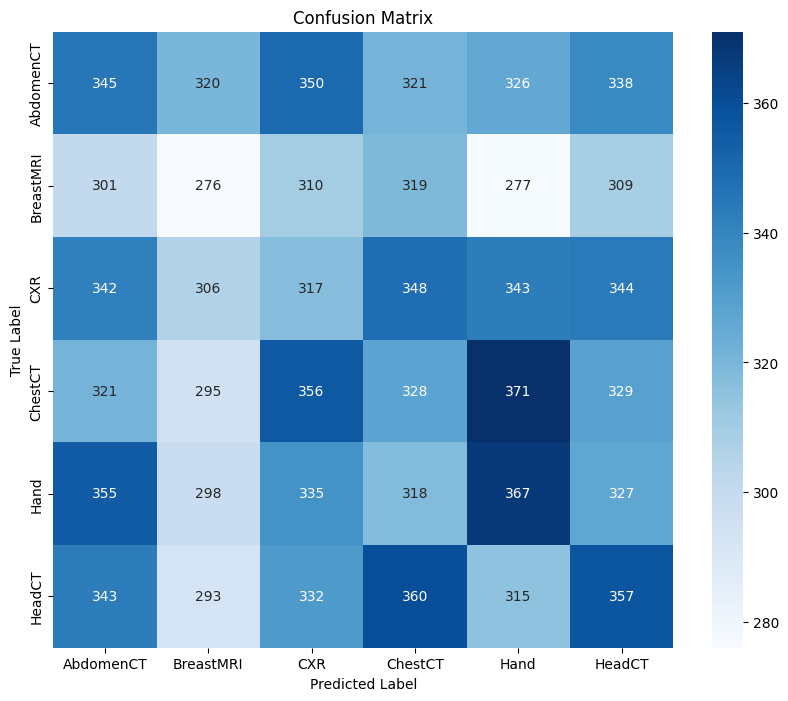

In [21]:
# Get the true labels from the test generator
true_classes = test.classes
class_labels = list(test.class_indices.keys())  # Get the class labels
print(true_classes)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
my_model = models.Sequential([
    #2D Convolutional Layer with 32 filters each of size 3x3
    #Shape of the input images are 48x48 pixels with 1 channel
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    #Max Pooling Layer with a 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    #2D Convolutional Layer with 64 filters each of size 3x3
    layers.Conv2D(64, (3, 3), activation='relu'),
    #Max Pooling Layer with a 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    #2D Convolutional Layer with 128 filters each of size 3x3
    layers.Conv2D(128, (3, 3), activation='relu'),
    #This Layer flattens the 3D output of the last Conv2D layer into 1D array
    layers.Flatten(),
    #A fully connected (Dense) layer with 256 neurons
    layers.Dense(256, activation='relu'),
    #Dense layer with 6 neurons corresponding to the 6 classes
    layers.Dense(6, activation='softmax')
])

my_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 346112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │      88,604,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,699,718 (338.36 MB)

 Trainable params: 88,699,718 (338.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model
my_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
)

history = my_model.fit(
    train,
    validation_data=validation,
    epochs=40,
    steps_per_epoch=30,       # Define steps per epoch explicitly
    validation_steps=20,       # Define validation steps explicitly
    callbacks=[early_stopping, reduce_learning_rate],
    shuffle=True
)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 644ms/step - accuracy: 0.8395 - loss: 0.4475 - precision: 0.8582 - recall: 0.8147 - val_accuracy: 0.8719 - val_loss: 0.2509 - val_precision: 0.8797 - val_recall: 0.8687 - learning_rate: 0.0010
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 614ms/step - accuracy: 0.9138 - loss: 0.2710 - precision: 0.9172 - recall: 0.8982 - val_accuracy: 0.8687 - val_loss: 0.3769 - val_precision: 0.8738 - val_recall: 0.8656 - learning_rate: 0.0010
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 698ms/step - accuracy: 0.8666 - loss: 0.3181 - precision: 0.8725 - recall: 0.8520 - val_accuracy: 0.8969 - val_loss: 0.2466 - val_precision: 0.9088 - val_recall: 0.8719 - learning_rate: 0.0010
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 571ms/step - accuracy: 0.8826 - loss: 0.2980 - precision: 0.8839 - recall: 0.8617 - val_accuracy: 0.8781 - val_loss: 0.2697 - val_precision: 0.8829 - val_recall: 0.8719 - learning_rate: 0.0010
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step - accur

In [32]:
# Evaluating the model on train and test
score = my_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])
print("Train Precision: ", score[2])
print("Train Recall: ", score[3])

score = my_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])
print("Test Precision: ", score[2])
print("Test Recall: ", score[3])

1106/1106 ━━━━━━━━━━━━━━━━━━━━ 501s 451ms/step - accuracy: 0.8970 - loss: 0.2939 - precision: 0.8987 - recall: 0.8955
Train Loss:  0.30028101801872253
Train Accuracy:  0.8958780765533447
Train Precision:  0.8974286317825317
Train Recall:  0.8939273953437805
737/737 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9242 - loss: 0.1669 - precision: 0.9244 - recall: 0.9238

Test loss:  0.16594648361206055
Test Accuracy:  0.9192672967910767
Test Precision:  0.9197860956192017
Test Recall:  0.9189280867576599


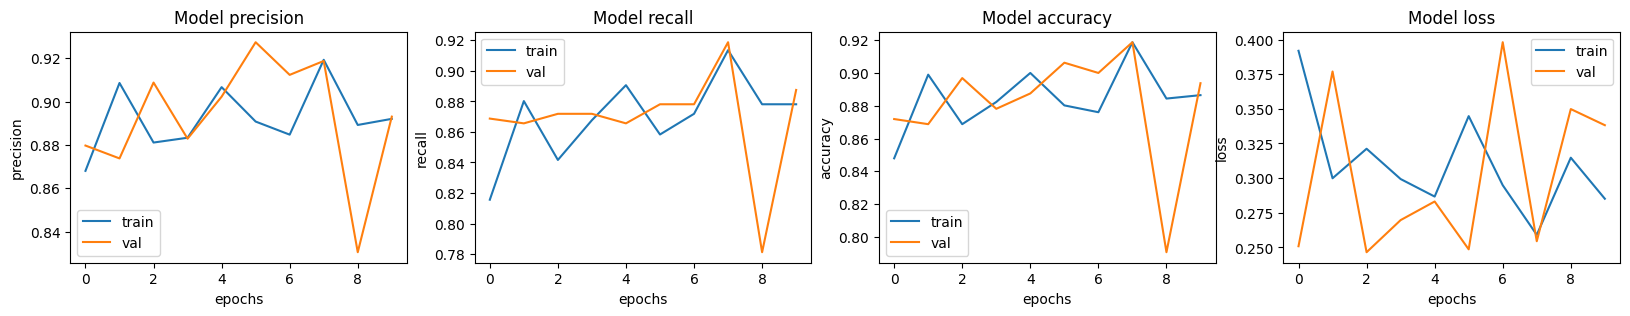

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
predictions = my_model.predict(test, steps=len(test), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

737/737 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


[0 0 0 ... 5 5 5]


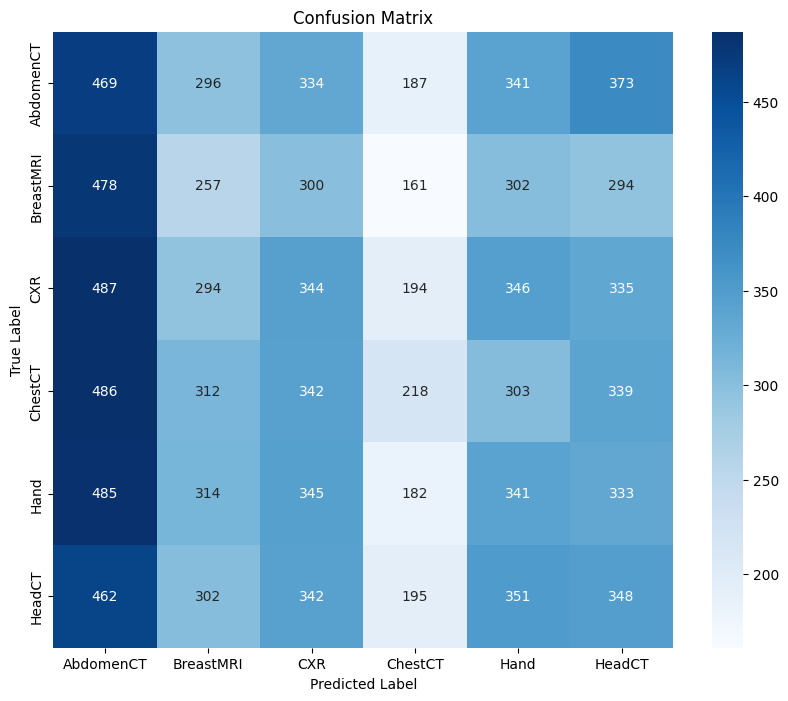

In [35]:
# Get the true labels from the test generator
true_classes = test.classes
class_labels = list(test.class_indices.keys())  # Get the class labels
print(true_classes)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()